<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Data Discovery and Query with the Butler</b> <br>
Contact author(s): Alex Drlica-Wagner, Melissa Graham <br>
Last verified to run: 2024-01-31 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Learn how to discover data and apply query constraints with the Butler. **Adapted to use the CC-IN2P3 butler.** 

**Skills:** Use the Butler registry, dataIds, and spatial and temporal constraints.

**LSST Data Products:** calexps, deepCoadds, sources

**Packages:** lsst.daf.butler, lsst.sphgeom

**Credit:** Elements of this tutorial were originally developed by Alex Drlica-Wagner in the context of the LSST Stack Club.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

In the introductory Butler tutorial, we learned how to access DP0 data given a specific data identifier (`dataId`). In this tutorial, we will explore how to use the Butler to find available data sets that match different sets of criteria (i.e., perform spatial and temporal searches). As a reminder, full Butler documentation can be found [in the documentation for lsst.dat.butler](https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/index.html). For this notebook in particular, you might find this set of [Frequently Asked Questions](https://pipelines.lsst.io/middleware/faq.html) for the LSST Science Pipelines middleware to be useful.

### 1.1 Package Imports

Import general python packages and several packages from the LSST Science Pipelines, including the Butler package and AFW Display, which can be used to display images.
More details and techniques regarding image display with `afwDisplay` can be found in the `rubin-dp0` GitHub Organization's [tutorial-notebooks](https://github.com/rubin-dp0/tutorial-notebooks) repository.

In [1]:
# Generic python packages
import numpy as np
import pylab as plt
import astropy.time

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.sphgeom
afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

### 1.2. Create an instance of the Butler

Create an instance of the Butler pointing to the DP0.2 data by specifying the `dp02` configuration and the `2.2i/runs/DP0.2` collection.

In [2]:
butler = dafButler.Butler('/sps/lsst/dataproducts/rubin/previews/dp0.2/', collections='2.2i/runs/FRDF/DP0.2/PREOPS-1145/step_all')

### 1.3. Create a function for image corners

In [3]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## 2. Explore the DP0 data repository

Butler repositories have both a database component and a file-like storage component.
The database component can be accessed through the Butler registry, while file-like storage can be local (i.e., pointing to a directory on the local file system) or remote (i.e., pointing to cloud storage resources).
DP0 uses Simple Storage Service (S3) buckets, which are public cloud storage resources that are similar to file folders.
The S3 buckets store objects, which consist of data and its descriptive metadata.

### 2.1. The Butler registry

The database side of a data repository is called a `registry`.
The registry contains entries for all data products, and organizes them by _collections_, _dataset types_, and _data IDs_.
We can access a registry client directly as part of our Butler object:

In [4]:
registry = butler.registry

Optional: learn more about the registry by uncommenting the following line.

In [5]:
# help(registry)

#### 2.1.1. queryCollections

Collections are lightweight groups of datasets such as the set of raw images for a particular instrument, self-consistent calibration datasets, and the outputs of a processing run.
For DP0.2, we use the `2.2i/runs/DP0.2` collection, which we specified when creating our instance of the Butler.

It is possible to access other collections, which can be queried with `queryCollections`. 
More about collections can be found in the [lsst.daf.butler documentation](https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/organizing.html#collections) and in the middleware [FAQ](https://pipelines.lsst.io/middleware/faq.html#querycollections).

> **Risk reminder:** for DP0 there are no read/write restrictions on the Butler repository.

The above risk means all users can see *everything* in the Butler, including intermediate processing steps, test runs, staff repositories, and other user repositories.
This fact makes the queryCollections functionality less useful for data discovery than it will be in the future, due to the sheer number of Butler collections exposed to users.

Optional: print a giant list of every collection that exists.

In [6]:
# for c in sorted(registry.queryCollections()):
#     print(c)

The only two collections that users need are the DP0.1 and DP0.2 collections.

In [8]:
for c in sorted(registry.queryCollections()):
    if (c == '2.2i/runs/DP0.1') | (c == '2.2i/runs/DP0.2'):
        print(c)

You can also find a list of collections that match a string or regular expression. For example, collections created by your friend, e.g., with username 'MelissaGraham'.

In [9]:
for c in sorted(registry.queryCollections("*MelissaGraham*")):
    print(c)

#### 2.1.2. queryDatasetTypes

As shown in the introductory Butler notebook, useful DP0.2 datasetTypes for images include deepCoadd, calexp, and goodSeeingDiff_differenceExp, while useful datasetTypes for catalogs include sourceTable, objectTable, diaObjectTable_tract, etc.
See the [DP0.2 Data Products Definitions Document](https://dp0-2.lsst.io/data-products-dp0-2/index.html#dp0-2-data-products-definition-document-dpdd) for more details about the DP0.2 data sets.

The queryDatasetTypes function allows users to explore available datasetTypes.

> **Notice:** as described in <a href="https://pipelines.lsst.io/middleware/faq.html#querydatasettypes">the documentation page for `queryDatasetTypes`</a>, this method will report *all* datasetTypes that have been registered with a data repository, even if there aren’t any datasets of that type actually present.

The queryDatasetTypes function is a useful tool when you know the name of the dataset type already, and want to see how it’s defined (i.e., what kind of dataId it accepts).

Optional: print a giant list of all the available dataset types.

In [10]:
# for dt in sorted(registry.queryDatasetTypes()):
#     print(dt)

You can provide a string or regular expression to queryDatasetTypes to list a subset of datasetTypes. For example, the following cell lists datasetTypes with names including '\_tract', which indicates that this dataset can be queried by tract.

In [11]:
for dt in sorted(registry.queryDatasetTypes('*_tract')):
    print(dt)

DatasetType('diaObjectTable_tract', {skymap, tract}, DataFrame)
DatasetType('diaSourceTable_tract', {skymap, tract}, DataFrame)
DatasetType('forcedSourceOnDiaObjectTable_tract', {skymap, tract}, DataFrame)
DatasetType('match_ref_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('match_target_truth_summary_objectTable_tract', {skymap, tract}, DataFrame)
DatasetType('objectTable_tract', {skymap, tract}, DataFrame)


Optional: list all the dataset types associated with deepCoadds.

In [12]:
# for dt in sorted(registry.queryDatasetTypes('deepCoadd*')):
#     print(dt)

Note that queryDatasetTypes returns a generator function, which is a special kind of function that can be iterated.
It contains objects that can be looped over like a list, as shown in the code cells above. 
Generator functions are used because they do not store their contents in memory, making them more suitable for really large data sets, like LSST.

#### 2.1.3. getDatasetType

If you want to retrieve a single datasetType rather than a generator function, you can use `getDatasetType`. Below, we get the datasetType associated with deepCoadd.

In [13]:
dt_deepCoadd = registry.getDatasetType('deepCoadd')
print(dt_deepCoadd)

DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)


#### 2.1.4. queryDimensionRecords

As described in the <a href="https://pipelines.lsst.io/middleware/faq.html#querydimensionrecords">documentation for `queryDimensionRecords`</a>,
this method provies a way to inspect metadata tables.

**Option:** print the different metadata elements that are available to be inspected.

In [14]:
# for a in butler.registry.dimensions.getStaticElements():
#     print(a)

A call to `queryDimensionRecords` will return a set of fields, depending on the element.

To first see the fields that would be returned for a given element, in this case "detector":

In [15]:
print(butler.registry.dimensions['detector'].RecordClass.fields)

detector: 
  instrument: str
  id: int
  full_name: str
  name_in_raft: str
  raft: str
  purpose: str


Use the `queryDimensionRecords` method to return some detector metadata available for DP0 images (LSSTCam-imSim), for detectors 6, 7, and 8 only.

In [16]:
list(butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam-imSim' "
                                           "AND detector.id IN (6..8)"))

[detector.RecordClass(instrument='LSSTCam-imSim', id=6, full_name='R01_S20', name_in_raft='S20', raft='R01', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSSTCam-imSim', id=7, full_name='R01_S21', name_in_raft='S21', raft='R01', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSSTCam-imSim', id=8, full_name='R01_S22', name_in_raft='S22', raft='R01', purpose='SCIENCE')]

**Option:** use the `queryDimensionRecords` method to return the exposure, visit, and detector metadata available for DP0 visit number 971990 and detector 0.

In [17]:
# for dim in ['exposure', 'visit', 'detector']:
#     print(list(registry.queryDimensionRecords(dim, where='visit = 971990 and detector = 0'))[0])
#     print()

### 2.2. Use a dataId with queryDatasets

The dataId is a dictionary-like identifier for a data product (more information can be found in the [lsst.daf.butler documentation](https://pipelines.lsst.io/modules/lsst.daf.butler/dimensions.html#data-ids)).
Each `DatasetType` (i.e., `calexp`, `deepCoadd`, `objectTable`, etc.) uses a different set of keys in its dataId, which are also called "dimensions".

Use the registry to get the DatasetType for a specific named dataset, in this case a `calexp`, and list its dimensions.

In [18]:
dt = registry.getDatasetType('calexp')
print("Name:", dt.name)
print("Dimensions:", dt.dimensions)
print("Storage Class:", dt.storageClass)

Name: calexp
Dimensions: {band, instrument, detector, physical_filter, visit_system, visit}
Storage Class: ExposureF


The dataId contains both *implied* and *required* keys.
For example, the value of `band` is *implied* by the `visit`, because a single visit refers to a single exposure at a single pointing in a single band.

In other tutorial notebooks, we have seen how to access a specific data product using a fully specified dataId. A query for a fully specified dataId should return one unique entry (however, see the [FAQ](https://pipelines.lsst.io/middleware/faq.html#why-do-queries-return-duplicate-results) entry about duplicate results from chained collections).

As described in the <a href="https://pipelines.lsst.io/middleware/faq.html#querydatasets">documentation page for `queryDatasets`</a>, this method returns `datasetRefs`, which can be passed directly to a call to `butler.get()` in order to retrieve the desired data (see next section).

In [19]:
datasetType = 'calexp'
dataId = {'visit': 192350, 'detector': 175}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])

{instrument: 'LSSTCam-imSim', detector: 175, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
band: i


A dataId can be represented as regular Python `dict` object, but when they are returned from the `Butler` the `DataCoordinate` class is used instead.
The value of a single key, in this case *band*, can also be printed by specifying the key name.

Note that when we instantiated the Butler pointing to the DP0.2 collection (i.e., at the beginning of this notebook), we implicitly specified that we are interested in data associated with the `LSSTCam-imSim` instrument, since that is the only instrument contained in the DP0.2 collection.

It is also possible to query for all data products that match a partially specified dataId.
For example, in the following cell we use a partially specified dataId to select all the `calexp` data associated with visit=192350.
This search will return a separate entry for each CCD detector that was processed for this visit (this visit happens to be close to the edge of the simulated footprint, so only 187 detectors were processed). 
We'll print information about a few of them. 

(The following cell will fail and return an error if the query is requesting a `DatasetRef` for data that does not exist.)

In [20]:
datasetType = 'calexp'
dataId = {'visit': 192350}
datasetRefs = set(registry.queryDatasets(datasetType, dataId=dataId))

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    if i > 2:
        print('...')
        break

print(f"Found {len(datasetRefs)} detectors")

{instrument: 'LSSTCam-imSim', detector: 28, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 58, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 131, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 125, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
...
Found 187 detectors


The LSST Science Camera has 189 science detectors, total, but this visit is very near the edge of the DC2 simulation region (only 300 square degrees of sky).

Note the use of the `set` method in the previous cell. 
If you remove the `set` command, you will find that `queryDatasets` returns duplicate entries for some detectors. 
This is the result of a conscious design choice in order to to handle large results efficiently. In essence, the SQL queries that are being executed "under the hood" are not attempting to remove duplicate entries. You can find a more extensive discussion of duplicate query entries in the [Middleware FAQ](https://pipelines.lsst.io/middleware/faq.html#why-do-queries-return-duplicate-results).

### 2.3. Use butler.get() with a datasetRef

One of the beauties of the Butler is that there is no need to know exactly where the data live in order to access it.
In previous notebooks we've seen how to pass a dataId to Butler.get to return an instance of the appropriate object.
When you already have a datasetRef, it is faster and more efficient to pass the datasetRef to Butler.get. 
Here we use Butler.get to retrieve the calexp and then get the detector Id from the calexp's properties.

In [21]:
for i, ref in enumerate(datasetRefs):
    calexp = butler.get(ref)
    print(i, ' calexp.detector.getId(): ', calexp.detector.getId())
    if i > 2:
        print('...')
        break

0  calexp.detector.getId():  28
1  calexp.detector.getId():  58
2  calexp.detector.getId():  131
3  calexp.detector.getId():  125
...


Optional: display the first four calexps retrieved from the Butler.

In [22]:
# for i, ref in enumerate(datasetRefs):
#     calexp = butler.get(ref)
#     print(i, ' calexp.detector.getId(): ', calexp.detector.getId())
#     fig = plt.figure()
#     display = afwDisplay.Display(frame=fig)
#     display.scale('asinh', 'zscale')
#     display.mtv(calexp.image)
#     plt.show()
#     if i > 2:
#         print('...')
#         break

## 3. Query the DP0 data repository

As TAP is the recommended way to query the catalogs, the following basic, temporal, and spatial query examples are all for images (calexps).

### 3.1. Basic image queries

Our example above demonstrated a very simple use of `queryDatasets`, but additional query terms can also be used, such as band and visit.
When a query term is an equality, it can be specified as an argument like `band=''`. 
When a query term is an inequality, it can be specified with `where`.
More details on Butler queries can be found [here in the lsst.daf.butler documentation](https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/queries.html).

In the following cell, we query for a list of all calexps corresponding i-band observations of a single detector over a range of visits.

In [23]:
datasetRefs = registry.queryDatasets(datasetType='calexp', band='i', detector=175,
                                     where='visit > 192000 and visit < 193000')

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)

{instrument: 'LSSTCam-imSim', detector: 175, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192351, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192353, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192354, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192355, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192356, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192357, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 175, visit: 192358, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}


Optional: use the datasetRefs to retrieve the calexp image, and display the first four.

In [24]:
# for i, ref in enumerate(datasetRefs):
#     calexp = butler.get(ref)
#     fig = plt.figure()
#     display = afwDisplay.Display(frame=fig)
#     display.scale('asinh', 'zscale')
#     display.mtv(calexp.image)
#     plt.show()
#     if i > 2:
#         print('...')
#         break

#### 3.1.1. Optional: retrieving temporal and spatial metadata

As a precursor to doing temporal and spatial queries below, we demonstrate the temporal and spatial metadata that can be retrieved for calexps via the Butler.

Retrieving only the metadata (calexp.visitInfo, calexp.bbox, or calexp.wcs) can be faster than retreiving the full calexp, and then extracting the metadata from it.

Print the full visitInfo record to screen.

In [25]:
for i, ref in enumerate(datasetRefs):
    visitInfo = butler.get('calexp.visitInfo', dataId=ref.dataId)
    print(visitInfo)

VisitInfo(exposureTime=30, darkTime=30, date=2022-09-15T09:07:20.140899826, UT1=nan, ERA=2.28122 rad, boresightRaDec=(53.6003547253, -32.7089000169), boresightAzAlt=(245.0397119707, +83.7529317472), boresightAirmass=1.00506, boresightRotAngle=3.47434 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=192350, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)
VisitInfo(exposureTime=30, darkTime=30, date=2022-09-15T09:08:00.748900099, UT1=nan, ERA=2.28419 rad, boresightRaDec=(52.3636782613, -35.9958442960), boresightAzAlt=(227.6773698597, +81.0873436980), boresightAirmass=1.01087, boresightRotAngle=3.16411 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=192351, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)
Vi

Print information from the visitInfo: the date, exposure time, and the boresight (the pointing coordinates of the telescope).

In [26]:
for i, ref in enumerate(datasetRefs):
    visitInfo = butler.get('calexp.visitInfo', dataId=ref.dataId)
    print(i, visitInfo.date, visitInfo.exposureTime, visitInfo.boresightRaDec)

0 DateTime("2022-09-15T09:07:20.140899826", TAI) 30.0 (53.6003547253, -32.7089000169)
1 DateTime("2022-09-15T09:08:00.748900099", TAI) 30.0 (52.3636782613, -35.9958442960)
2 DateTime("2022-09-15T09:09:22.915099862", TAI) 30.0 (50.8415002597, -42.6478842974)
3 DateTime("2022-09-15T09:10:01.795099843", TAI) 30.0 (54.5372572359, -40.1834782290)
4 DateTime("2022-09-15T09:10:40.761799838", TAI) 30.0 (56.2862239385, -35.0230765514)
5 DateTime("2022-09-15T09:11:19.641799818", TAI) 30.0 (58.4357468320, -33.0205890574)
6 DateTime("2022-09-15T09:12:02.755099887", TAI) 30.0 (55.7954543284, -41.4556164216)
7 DateTime("2022-09-15T09:12:41.635099867", TAI) 30.0 (55.4352486275, -39.3319483539)


Print spatial information from the bounding box (bbox) and world coordinate system (wcs) metadata: the four corners of the image.

In [27]:
for i, ref in enumerate(datasetRefs):
    bbox = butler.get('calexp.bbox', dataId=ref.dataId)
    wcs = butler.get('calexp.wcs', dataId=ref.dataId)
    crnr_ra, crnr_dec = get_corners_radec(wcs, bbox)
    tmp = ''
    for c in range(4):
        tmp += f'({crnr_ra[c]:.3f},{crnr_dec[c]:.3f}) '
    print(i, tmp)

0 (52.963,-33.900) (52.875,-34.109) (53.133,-34.184) (53.221,-33.974) 
1 (52.188,-37.293) (52.182,-37.514) (52.467,-37.519) (52.473,-37.297) 
2 (51.183,-43.928) (51.268,-44.141) (51.571,-44.078) (51.484,-43.865) 
3 (55.075,-41.423) (55.193,-41.626) (55.470,-41.536) (55.352,-41.333) 
4 (56.492,-36.317) (56.551,-36.533) (56.826,-36.484) (56.766,-36.268) 
5 (58.699,-34.306) (58.767,-34.521) (59.032,-34.463) (58.963,-34.249) 
6 (56.596,-42.617) (56.757,-42.804) (57.017,-42.682) (56.855,-42.496) 
7 (56.038,-40.552) (56.165,-40.751) (56.433,-40.652) (56.305,-40.453) 


Optional: view the help documentation for a datasetRef.

In [28]:
# help(ref)

> **Tip!** In the case where metadata is desired for many images at once, you can avoid the time-consuming use of butler.get for individual dataIds by retrieving expanded datasetRefs.

In [29]:
datasetRefs = butler.registry.queryDatasets(datasetType='calexp', band='i', detector=175,
                                            where='visit > 192000 and visit < 193000')
expanded_datasetRefs = datasetRefs.expanded()

In [30]:
for i, ref in enumerate(expanded_datasetRefs):
    record = ref.dataId.records["visit"]
    print(i, record.id, record.exposure_time, record.timespan, record.region.getBoundingBox())

0 192350 30.0 [2022-09-15T09:07:05, 2022-09-15T09:07:35) Box([0.8933399435361895, 0.9772575716677872], [-0.6061470685727063, -0.5355792836436872])
1 192351 30.0 [2022-09-15T09:07:45, 2022-09-15T09:08:15) Box([0.8746909495312298, 0.9522135881631125], [-0.6594148394681437, -0.5968504795232021])
2 192353 30.0 [2022-09-15T09:09:07, 2022-09-15T09:09:37) Box([0.8404055595335118, 0.9351141173916367], [-0.7791241542029297, -0.7094892741294359])
3 192354 30.0 [2022-09-15T09:09:46, 2022-09-15T09:10:16) Box([0.9052743096160711, 0.9988246313418908], [-0.7370553056323268, -0.6655943815542783])
4 192355 30.0 [2022-09-15T09:10:25, 2022-09-15T09:10:55) Box([0.9409751100908125, 1.0244567661686226], [-0.6453842818240588, -0.5770618372743993])
5 192356 30.0 [2022-09-15T09:11:04, 2022-09-15T09:11:34) Box([0.9788809681881151, 1.0614534217123552], [-0.6108848328050508, -0.5416874215742732])
6 192357 30.0 [2022-09-15T09:11:47, 2022-09-15T09:12:17) Box([0.925641448701163, 1.0219349220995742], [-0.759627066683

### 3.2. Temporal image queries

The following examples show how to query for data sets that include a desired coordinate and observation date.

Since we only need to get the date and time that the exposure was taken, we can start by retrieving only the visitInfo associated with the calexp specified by our dataId (this will be faster than retrieving the full calexp).

In [31]:
dataId = {'visit': 192350, 'detector': 175}
visitInfo = butler.get('calexp.visitInfo', dataId=dataId)
print(visitInfo)

VisitInfo(exposureTime=30, darkTime=30, date=2022-09-15T09:07:20.140899826, UT1=nan, ERA=2.28122 rad, boresightRaDec=(53.6003547253, -32.7089000169), boresightAzAlt=(245.0397119707, +83.7529317472), boresightAirmass=1.00506, boresightRotAngle=3.47434 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=192350, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)


To query for dimension records or datasets that overlap an arbitrary time range, we can use the `bind` argument to pass times through to `where`.
Using `bind` to define an alias for a variable saves us from having to string-format the times into the `where` expression.
Note that a `dafButler.Timespan` will accept a `begin` or `end` value that is equal to `None` if it is unbounded on that side.

Use `bind` and `where`, along with [astropy.time](https://docs.astropy.org/en/stable/time/index.html), to query for calexps that were obtained within +/- 10 minutes of the calexp defined by the dataId above.

In [32]:
time = astropy.time.Time(visitInfo.date.toPython())
minute = astropy.time.TimeDelta(60, format="sec")
timespan = dafButler.Timespan(time - 10*minute, time + 10*minute)

print(time)
print(minute)
print(timespan)

2022-09-15 09:07:20.140900
60.0
[2022-09-15T08:57:57, 2022-09-15T09:17:57)


In [33]:
datasetRefs = registry.queryDatasets("calexp",
                                     where="visit.timespan OVERLAPS my_timespan",
                                     bind={"my_timespan": timespan})

In [34]:
for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    if i > 6:
        print('...')
        break

print(f"Found {len(list(datasetRefs))} calexps")

{instrument: 'LSSTCam-imSim', detector: 156, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 67, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 159, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 115, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 109, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 155, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 113, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
{instrument: 'LSSTCam-imSim', detector: 112, visit: 192352, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1}
...
Found 1636 calexps


How many unique visits were obtained within the DC2 area within +/- 10 minutes of the calexp defined above?

In [35]:
temp = []
for i, ref in enumerate(datasetRefs):
    temp.append(ref.dataId['visit'])

unique_visitIds = np.unique(np.sort(np.asarray(temp, dtype='int')))

print('Number of unique visits: ', len(unique_visitIds))
print('visitIds for the unique visits: ', unique_visitIds)

del temp

Number of unique visits:  13
visitIds for the unique visits:  [192347 192348 192350 192351 192352 192353 192354 192355 192356 192357
 192358 192359 192360]


The maximum number of visits that can be executed in 20 minutes is about 34 visits. The reason why we find only 13 is because for DC2 the [minion\_1016 observing strategy](https://docushare.lsst.org/docushare/dsweb/View/Collection-4604) baseline simulation was used, and minion\_1016 simulates observations over the whole sky but DC2 covers only 300 square degrees. 

### 3.3. Spatial image queries

#### 3.3.1. Overlapping images

As a simple first example, we search for deepCoadd images that overlap a particular calexp. 

We again start by grabbing the visitInfo for the same calexp.

In [36]:
dataId = {'visit': 192350, 'detector': 175}
visitInfo = butler.get('calexp.visitInfo', dataId=dataId)
print(visitInfo)

VisitInfo(exposureTime=30, darkTime=30, date=2022-09-15T09:07:20.140899826, UT1=nan, ERA=2.28122 rad, boresightRaDec=(53.6003547253, -32.7089000169), boresightAzAlt=(245.0397119707, +83.7529317472), boresightAirmass=1.00506, boresightRotAngle=3.47434 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=192350, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)


If we query for `deepCoadd` datasets with a `visit`+`detector` dataId, we'll get just the deepCoadd objects that overlap that observation and have the same band (because a visit implies a band).
This is a very simple spatial query for data that overlaps other data.

In [37]:
for ref in set(registry.queryDatasets("deepCoadd", dataId=dataId)):
    print(ref)

deepCoadd@{band: 'i', skymap: 'DC2', tract: 4024, patch: 47} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step3_17/20220604T200936Z id=f3ee45bf-0ac5-494e-bd1f-8b4c99c2fb9d)
deepCoadd@{band: 'i', skymap: 'DC2', tract: 4225, patch: 2} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step3_19/20220609T081700Z id=8acfdb58-ac67-4f18-9d2a-8a54521edeb7)
deepCoadd@{band: 'i', skymap: 'DC2', tract: 4225, patch: 3} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step3_19/20220609T081700Z id=5aefe3c2-acb0-4bd7-889d-d86cfe21f002)
deepCoadd@{band: 'i', skymap: 'DC2', tract: 4225, patch: 10} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step3_19/20220609T081700Z id=c627a5ab-efc9-4da8-bffa-cbd95bc6988f)
deepCoadd@{band: 'i', skymap: 'DC2', tract: 4024, patch: 48} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step3_17/20220617T115003Z id=a9b5660a-f962-48d4-bda7-b55752a2c381)
deepCoadd@{band: 'i', skymap: 'DC2', tract: 4225, patch: 9} [sc=ExposureF] (run=2.2i/runs/FRDF/DP

Use the corners of the `calexp` and of the overlapping `deepCoadd` patches to trace the image edges in a plot, and show the overlap.

In the plot below, the `deepCoadd` tract and patch (4024, 48) does not quite overlap with the original `calexp`.
That is because the visit and detector region from the `calexp` WCS and bounding box is not quite the same as the region in the database, which is based on the raw WCS with some padding.

In [38]:
calexp_wcs = butler.get('calexp.wcs', dataId=dataId)
calexp_bbox = butler.get('calexp.bbox', dataId=dataId)
calexp_corners_ra, calexp_corners_dec = get_corners_radec(calexp_wcs, calexp_bbox)

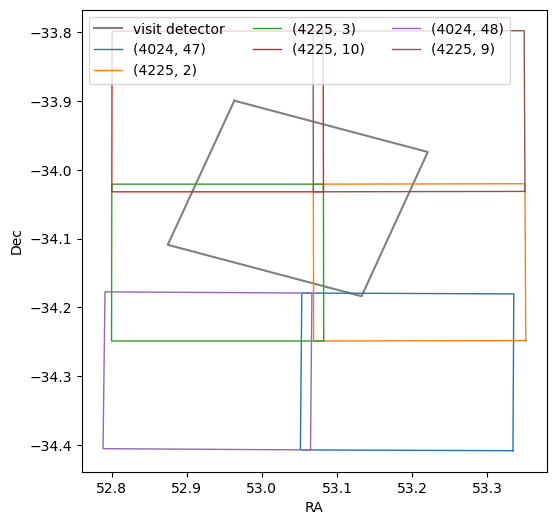

In [39]:
fig = plt.figure(figsize=(6, 6))

xvals = [calexp_corners_ra[0], calexp_corners_ra[1], calexp_corners_ra[2], \
         calexp_corners_ra[3], calexp_corners_ra[0]]
yvals = [calexp_corners_dec[0], calexp_corners_dec[1], calexp_corners_dec[2], \
         calexp_corners_dec[3], calexp_corners_dec[0]]
plt.plot(xvals, yvals, ls='solid', color='grey', label='visit detector')
del xvals, yvals

for r, ref in enumerate(set(registry.queryDatasets("deepCoadd", dataId=dataId))):
    deepCoadd_dataId = ref.dataId
    str_tract_patch = '(' + str(ref.dataId['tract']) + ', ' + str(ref.dataId['patch'])+')'
    deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=deepCoadd_dataId)
    deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=deepCoadd_dataId)
    deepCoadd_corners_ra, deepCoadd_corners_dec = get_corners_radec(deepCoadd_wcs, deepCoadd_bbox)
    xvals = [deepCoadd_corners_ra[0], deepCoadd_corners_ra[1], deepCoadd_corners_ra[2], \
             deepCoadd_corners_ra[3], deepCoadd_corners_ra[0]]
    yvals = [deepCoadd_corners_dec[0], deepCoadd_corners_dec[1], deepCoadd_corners_dec[2], \
             deepCoadd_corners_dec[3], deepCoadd_corners_dec[0]]
    plt.plot(xvals, yvals, ls='solid', lw=1, label=str_tract_patch)
    del xvals, yvals
    del deepCoadd_dataId, deepCoadd_wcs, deepCoadd_bbox
    del deepCoadd_corners_ra, deepCoadd_corners_dec

plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(loc='upper left', ncol=3)
plt.show()

#### 3.3.2. User-defined spatial constraints on images

Arbitrary spatial queries are not supported at this time, such as the "POINT() IN (REGION)" example found in this [Butler queries](https://pipelines.lsst.io/v/weekly/modules/lsst.daf.butler/queries.html) documentation.
In other words, at this time it is only possible to do queries involving regions that are already "in" the data repository, either because they are hierarchical triangular mesh (HTM) pixel regions or because they are tract/patch/visit/visit+detector regions.

Thus, for this example we use the set of dimensions that correspond to different levels of the HTM pixelization of the sky ([HTM primer](http://www.skyserver.org/htm/)).
The process is to transform a region or point into one or more HTM identifiers (HTM IDs), and then create a query using the HTM ID as the spatial dataId.
The `lsst.sphgeom` library supports region objects and HTM pixelization in the LSST Science Pipelines.

Using the `lsst.sphgeom` package, initialize a sky pixelization to level 10 (the level at which one sky pixel is about five arcmin radius).

In [40]:
level = 10  # the resolution of the HTM grid
pixelization = lsst.sphgeom.HtmPixelization(level)

Find the HTM ID for a desired sky coordinate. Below, the RA and Dec could be user-specified, but here we use the telescope boresight accessed from the calexp visitInfo retrieved above.

In [41]:
ra, dec = visitInfo.boresightRaDec
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra.asDegrees(), dec.asDegrees())
    )
)

Obtain and print the scale to provide a sense of the size of the sky pixelization being used. The opening angle for the circle is "the angle between its center vector and points on its boundary", i.e., the radius (from the [documentation for .getOpeningAngle in doxygen](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1sphgeom_1_1_circle.html#aa112ddd08e8445f67db9877a74d8a5c8)).

In [42]:
circle = pixelization.triangle(htm_id).getBoundingCircle()
scale = circle.getOpeningAngle().asDegrees()*3600.
level = pixelization.getLevel()
print(f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

HTM ID=9415276 at level=10 is bounded by a circle of radius ~279.99 arcsec.


In [43]:
small_timespan = dafButler.Timespan(time - minute, time + minute)

Pass the htm_id to the queryDatasets command, and also apply the same timespan constraints as above.

In [44]:
datasetRefs = registry.queryDatasets("calexp", htm20=htm_id,
                                     where="visit.timespan OVERLAPS my_timespan",
                                     bind={"my_timespan": small_timespan})

for i, ref in enumerate(datasetRefs):
    print(ref)
    if i > 6:
        print('...')
        break

print(f"Found {len(list(datasetRefs))} calexps")

calexp@{instrument: 'LSSTCam-imSim', detector: 94, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=9db0744d-c38c-4c82-80d7-9520f0b0c4c1)
Found 1 calexps


Thus, with the above query, we have *uniquely* recovered the visit for our desired temporal and spatial constraints.

Note that since we used the boresight as the RA, Dec for the `htm_id` and not the center of detector 175, a different detector (one in the center of the focal plane) has been returned - but the point here is that it is the same visit, 192350.

Note that if a smaller HTM level is used (like 7), which is a larger sky pixel (~2200 arcseconds), the above query will return many more visits and detectors which overlap with that larger region. Try it and see!

#### 3.3.3. queryDataIds

The level 7 HTM IDs that overlap each visit and detector are already loaded into the registry and can accessed directly using queryDataIds.
This will be a faster and more efficient way to look-up overlapping regions, but use of `queryDataIds` is a less general approach that is not appropriate for all cases.
The <a href="https://pipelines.lsst.io/middleware/faq.html#querydataids">documentation page for `queryDataIds`</a> outlines when not to use it.

In [45]:
for i, data_id in enumerate(registry.queryDataIds("htm7", where="visit = 192350 and detector = 175")):
    print(data_id)

{htm7: 147116}
{htm7: 147119}


In [46]:
datasetRefs = registry.queryDatasets("calexp", htm7=147116,
                                     where="visit.timespan OVERLAPS my_timespan",
                                     bind={"my_timespan": small_timespan})

for i, ref in enumerate(datasetRefs):
    print(ref)
    if i > 6:
        print('...')
        break

print(f"Found {len(list(datasetRefs))} calexps that overlap with htm7 = 147116")

calexp@{instrument: 'LSSTCam-imSim', detector: 139, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=9654e1e0-f7ec-443f-a54f-eccd2faab279)
calexp@{instrument: 'LSSTCam-imSim', detector: 140, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=9c3bdb98-b0f6-4b08-8bfc-0e24186e7d12)
calexp@{instrument: 'LSSTCam-imSim', detector: 142, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=62120bb4-7885-4bb7-9be0-a651b3a6c409)
calexp@{instrument: 'LSSTCam-imSim', detector: 143, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=ExposureF] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=5265d253-6a70-4c28-b922-d2b46b000e7a)
calexp@{instrument: 'LSS

### 3.4. Catalog spatial and temporal queries

The recommended method for querying and retrieving catalog data is to use the TAP service, as demonstrated in other tutorials.
However, it is also possible to query catalog data using the same HTM ID and same temporal constraints as used for images, above.

The Butler's spatial reasoning is designed to work well for regions the size of full data products, like detector- or patch-level images and catalogs, and it's a poor choice for smaller-scale searches.
The following search is a bit slow in part because `queryDatasets` searches for all `src` datasets that overlap a larger region and then filters the results down to the specified HTM ID pixel.

In [47]:
for i, src_ref in enumerate(registry.queryDatasets("source", htm20=htm_id, band="i",
                                                   where="visit.timespan OVERLAPS my_timespan",
                                                   bind={"my_timespan": small_timespan})):
    print(src_ref)
    sources = butler.get(src_ref)
    print('Number of sources: ', len(sources))
    if i > 2:
        print('...')
        break

source@{instrument: 'LSSTCam-imSim', detector: 94, visit: 192350, band: 'i', physical_filter: 'i_sim_1.4', visit_system: 1} [sc=DataFrame] (run=2.2i/runs/FRDF/DP0.2/PREOPS-1145/step1_1/20220413T151645Z id=59662497-5c86-43d3-9853-d4023f68077a)
Number of sources:  2290


Show the contents of the last source table retrieved from the Butler.
Notice that both the rows and the columns of the table are truncated.

In [48]:
sources

,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,...,ext_photometryKron_KronFlux_apCorr,ext_photometryKron_KronFlux_apCorrErr,ext_photometryKron_KronFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,calib_astrometry_used,calib_photometry_used,calib_photometry_reserved,ccdVisitId
id,,,,,,,,,,,,,,,,,,,,,
103267170389065729,0.934055,-0.568410,0,False,False,False,False,0,False,NaN,...,1.040659,0.0,False,NaN,True,67,False,False,False,192350094
103267170389065730,0.934241,-0.568464,0,False,False,False,False,0,False,NaN,...,1.041038,0.0,False,NaN,True,138,False,False,False,192350094
103267170389065731,0.934969,-0.568675,0,False,False,False,False,0,False,NaN,...,1.042161,0.0,False,NaN,True,85,False,False,False,192350094
103267170389065732,0.935404,-0.568800,0,True,False,False,False,0,False,NaN,...,1.042557,0.0,False,NaN,True,286,False,False,False,192350094
103267170389065733,0.935944,-0.568956,0,False,False,False,False,0,False,NaN,...,1.042766,0.0,False,NaN,True,58,False,False,False,192350094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103267170389068014,0.936796,-0.573223,103267170389067564,False,False,False,False,0,True,3876.0,...,1.039705,0.0,False,NaN,True,547,False,False,False,192350094
103267170389068015,0.933325,-0.572254,103267170389067576,False,False,False,False,0,True,707.0,...,1.029616,0.0,False,1.0,False,385,False,False,False,192350094
103267170389068016,0.933342,-0.572257,103267170389067576,False,False,False,False,0,True,722.0,...,1.029702,0.0,False,NaN,True,345,False,False,False,192350094


## 4. Explore metadata for butler-retrieved data products

Data retrieved from the butler is enriched with metadata.

The following provides a cursory overview of how to explore this metadata for image and catalog data retrieved via the butler.

In some cases these options were already covered in the sections above, but have been gathered here for easy reference.

### 4.1. Image data

Retrieve a `calexp` for a given visit and detector.

In [49]:
calexp = butler.get('calexp', dataId={'visit': 192350, 'detector': 94})

Get the information (metadata) available for this calexp.

In [50]:
calexp_info = calexp.getInfo()

**Option:** uncomment the following cell, put the cursor after the period, and press the tab key. 
A pop-up window will display the methods available for `calexp_info`.

In [51]:
# calexp_info.

**Option:** alternatively, print all options that would display in the pop-up window from the above cell.

In [52]:
# [m for m in dir(calexp_info) if not m.startswith('_')]

Obtain the visit and weather information for this calexp.

In [53]:
visit_info = calexp_info.getVisitInfo()
weather_info = visit_info.getWeather()

Print the weather information for this visit.

In [54]:
print(weather_info.getAirPressure())
print(weather_info.getAirTemperature())
print(weather_info.getHumidity())

nan
nan
40.0


**Option:** explore other aspects of the metadata, for example, detector information.

In [55]:
# [m for m in dir(calexp_info.getDetector()) if not m.startswith('_')]

### 4.2. Catalog data

Retrieve sources from the `src` table for a given visit and detector.

In [56]:
src_cat = butler.get('src', dataId={'visit': 192350, 'detector': 94})

**Option:** uncomment the following cell, put the cursor after the period, and press the tab key. 
A pop-up window will display the options available for the retrieved data product.

In [57]:
# src_cat.

**Option:** uncomment and execute the following cell in order to print the table retrieved (it will be truncated).

In [58]:
# src_cat

Get the names of the columns available in the schema for this data product.

In [59]:
columns = src_cat.schema.getNames()

**Option:** uncomment and execute the following cell in order to list all columns (it is a very long list).

In [60]:
# columns

List only the first part of all column names, before the underscore. This shows the different types of columns available.

In [61]:
src_cat.getSchema().getNames(topOnly=True)

{'base', 'calib', 'coord', 'deblend', 'detect', 'ext', 'id', 'parent', 'sky'}

To view the information for only a given element, use the `find` method.

In [62]:
src_cat.getSchema().find('id')

SchemaItem(key=Key<L>(offset=0, nElements=1), field=Field['L'](name="id", doc="unique ID"))